# Бустинг и Стекинг

## 1. Ансамбли

Зачем нужны ансамбли?  
Одна модель может иметь недостатки, например, недостаточное качество или склонность к переобучению.
Поэтому можно брать много одинаковых моделей меньшей сложности и агрегировать результаты от них.
Еще один плюс – некоторые модели позволяют определять, какие признаки важнее других.

Обычно мы строим ансамбли на деревьях (кроме стекинга)

Какие бывают ансамбли:
* Бэггинг
* Бустинг
* Стекинг

## 2. Модели, основанные на ансамблях

### 2.1. Случайный лес (Random Forest)

Случайный лес - каждое дерево строится независимо от остальных, потом ответ усредняется.
* +: процесс обучения можно распараллелить.
* +: простота реализации.
* +: сложнее переобучиться.
* -: слабая модель, может не уловить сложные зависимости в данных.

### 2.2. Анализ качества ансамбля

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import rfpimp

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

sns.set()
np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### Настройка параметров
Сгенерируем два класса точек на плоскости.

In [ ]:
n_points = 2000
x = np.vstack([np.random.normal(loc=0.8, size=(n_points, 2)),
               np.random.normal(loc=-0.8, size=(n_points, 2))])
y = np.array([0] * n_points + [1] * n_points)

In [ ]:
def plot_predictions(X, y, clf, proba=False, points_size=7):
    """Fits the classifier on the data (X, y) and plots the result on a 2-D plane."""
    def get_grid(data):
        x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
        y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
        return np.meshgrid(np.arange(x_min, x_max, 0.01),
                           np.arange(y_min, y_max, 0.01))
    
    clf.fit(X, y)
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
    plt.figure(figsize=(10.0, 10.0))
    plt.pcolormesh(xx, yy, predicted, cmap=plt.cm.RdBu, alpha=0.1, shading='auto')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=points_size, cmap=plt.cm.RdBu, alpha=0.90)
    plt.ylim([yy.min(),yy.max()])
    plt.xlim([xx.min(),xx.max()])
    plt.xlabel('x')
    plt.ylabel('y')
    
    return clf

Обучим случайный лес со стандартными параметрами.

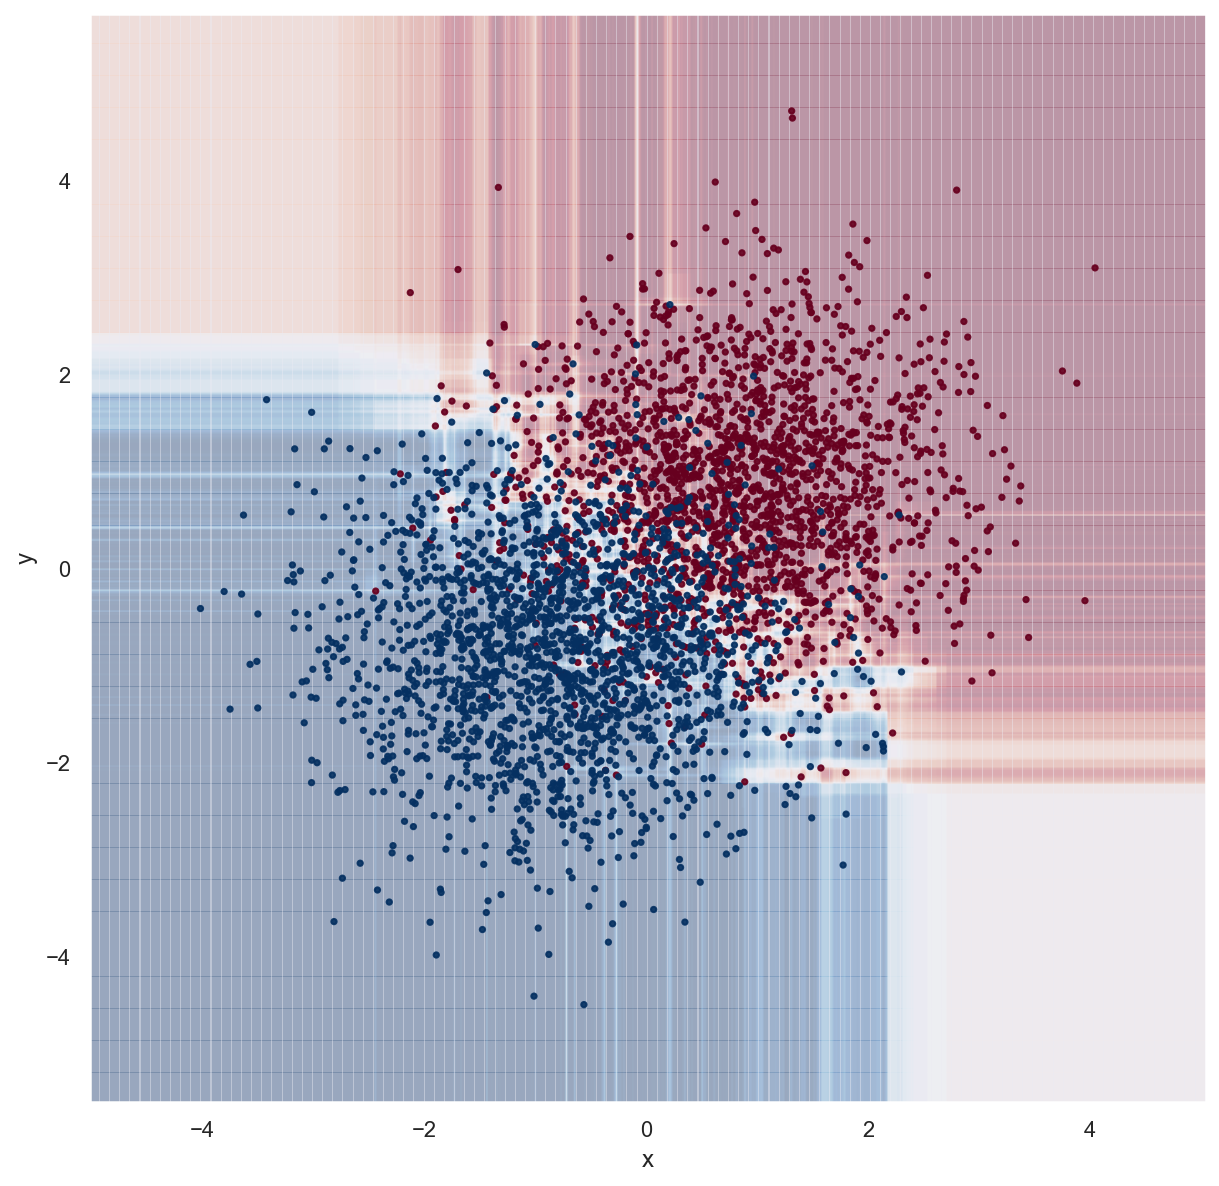

In [ ]:
clf = RandomForestClassifier()
plot_predictions(x, y, clf, proba=True);

Можно заметить что есть некоторый эффект переобучения: полоски вокруг объектов-выбросов.  
На влияние выбросов можно повлиять изменяя следующие параметры:
* максимальная глубину дерева: `max_depth`
* максимальное число листьев: `max_leaf_nodes`
* минимальное число объектов в листе дерева: `min_samples_leaf`
* минимальное число объектов во внутренней вершине дерева, при котором ее нужно разделить: `min_samples_split`  

Все эти параметры накладывают ограничения на структуру дерева, а значит они отвечают за настройку одного и того же, но немного по разному. Поэтому комбинировать их излишне и скорее всего не принесет заметной пользы.  
По сути все эти параметры обменивают bias на variance.

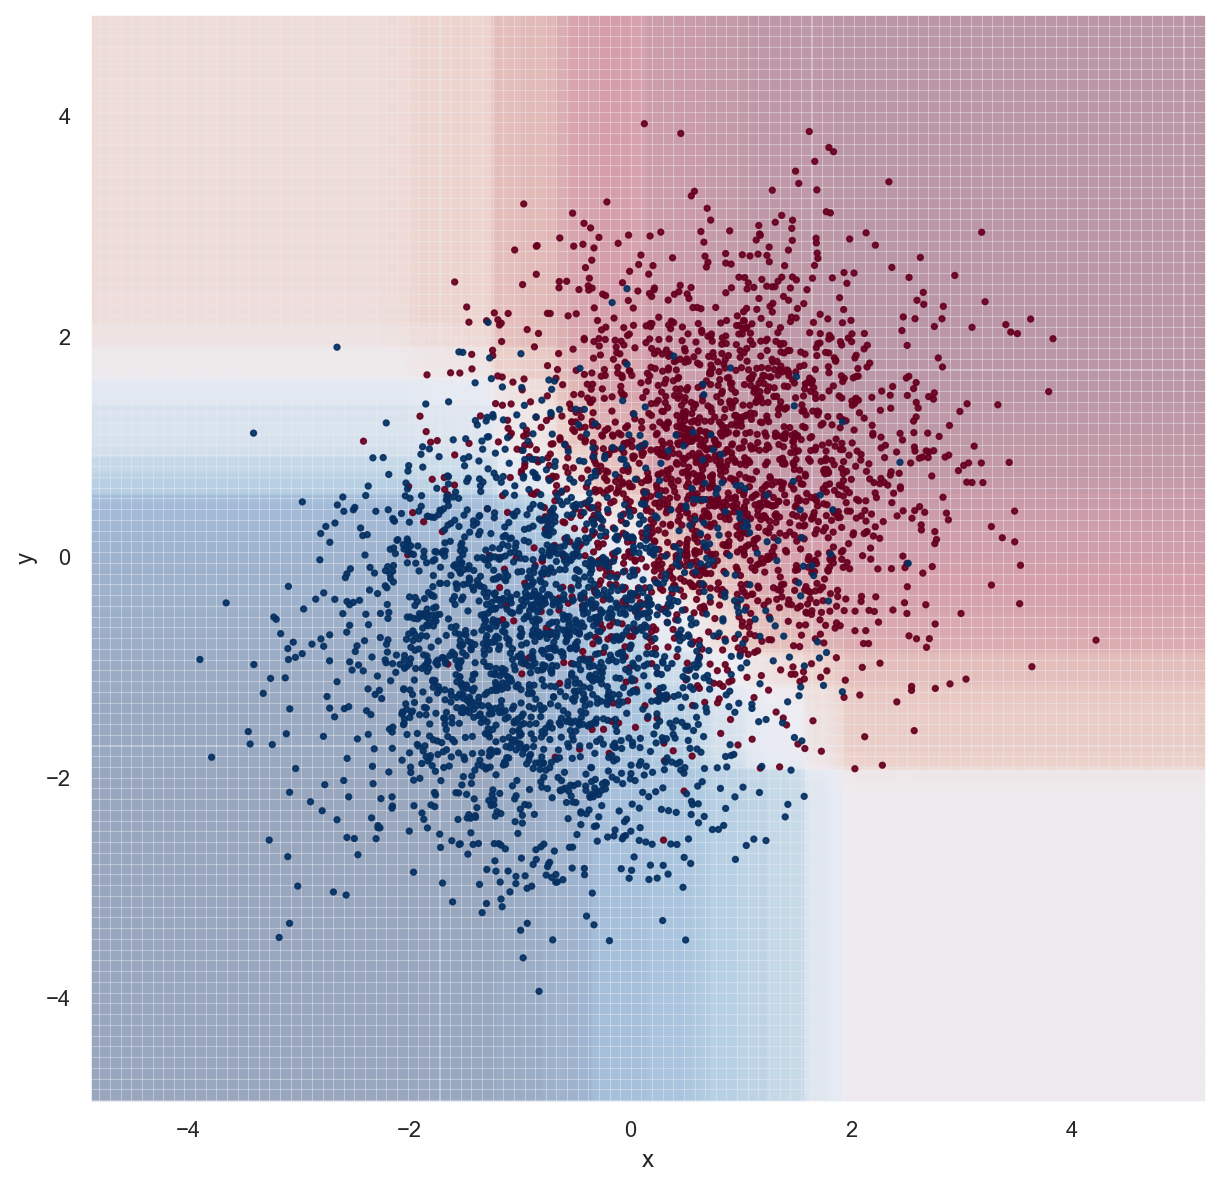

In [ ]:
clf = RandomForestClassifier(max_depth=4)
plot_predictions(x, y, clf, proba=True);

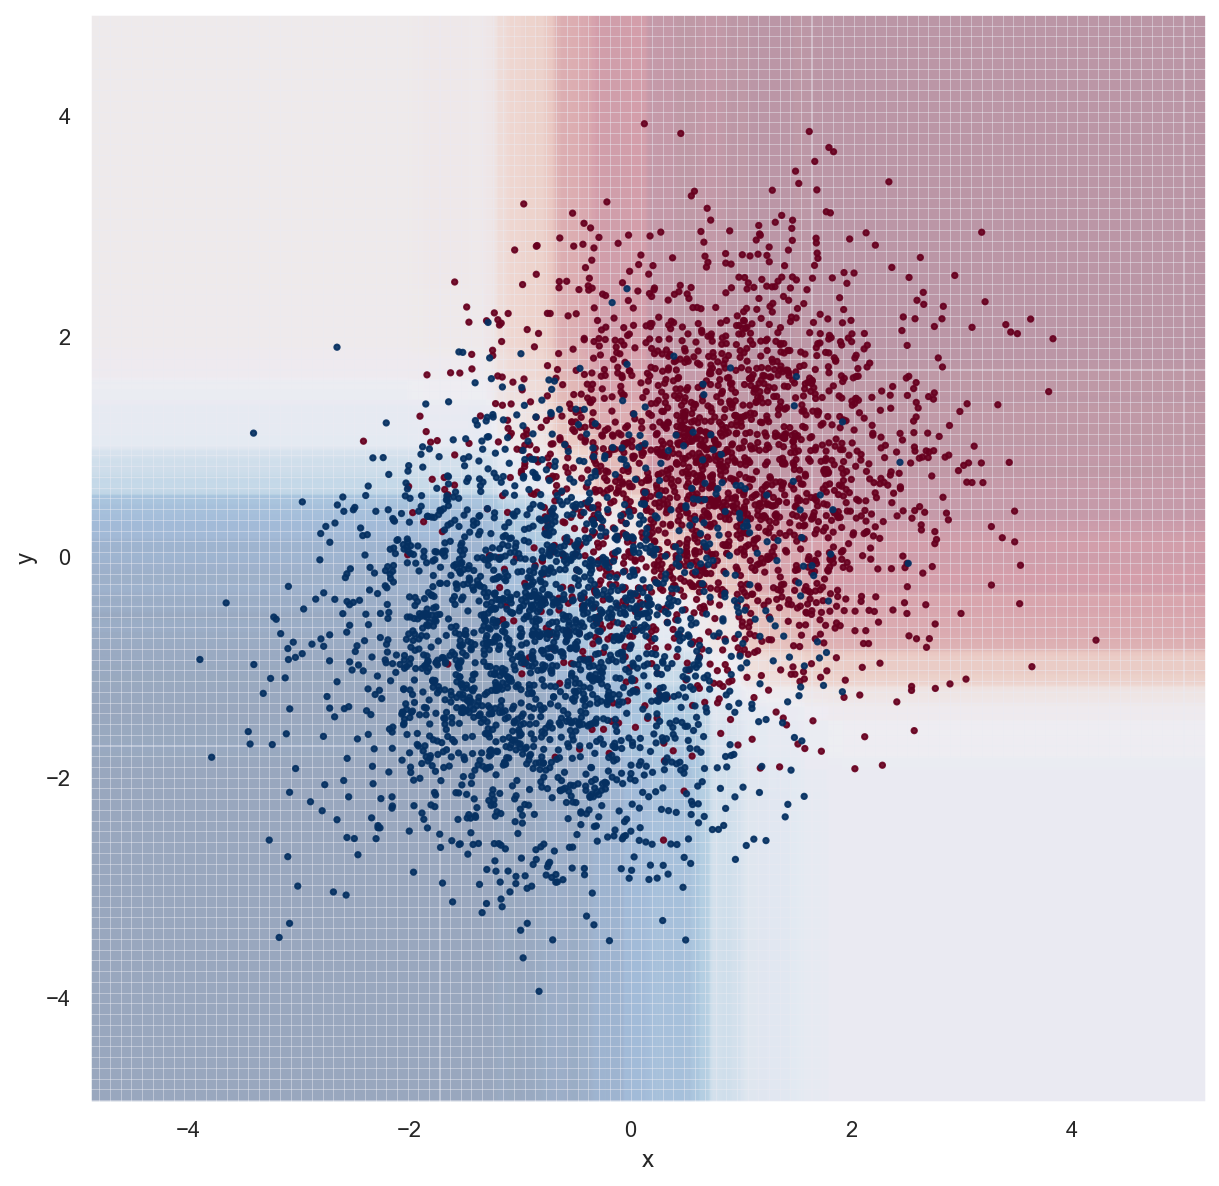

In [ ]:
clf = RandomForestClassifier(min_samples_leaf=50)
plot_predictions(x, y, clf, proba=True);

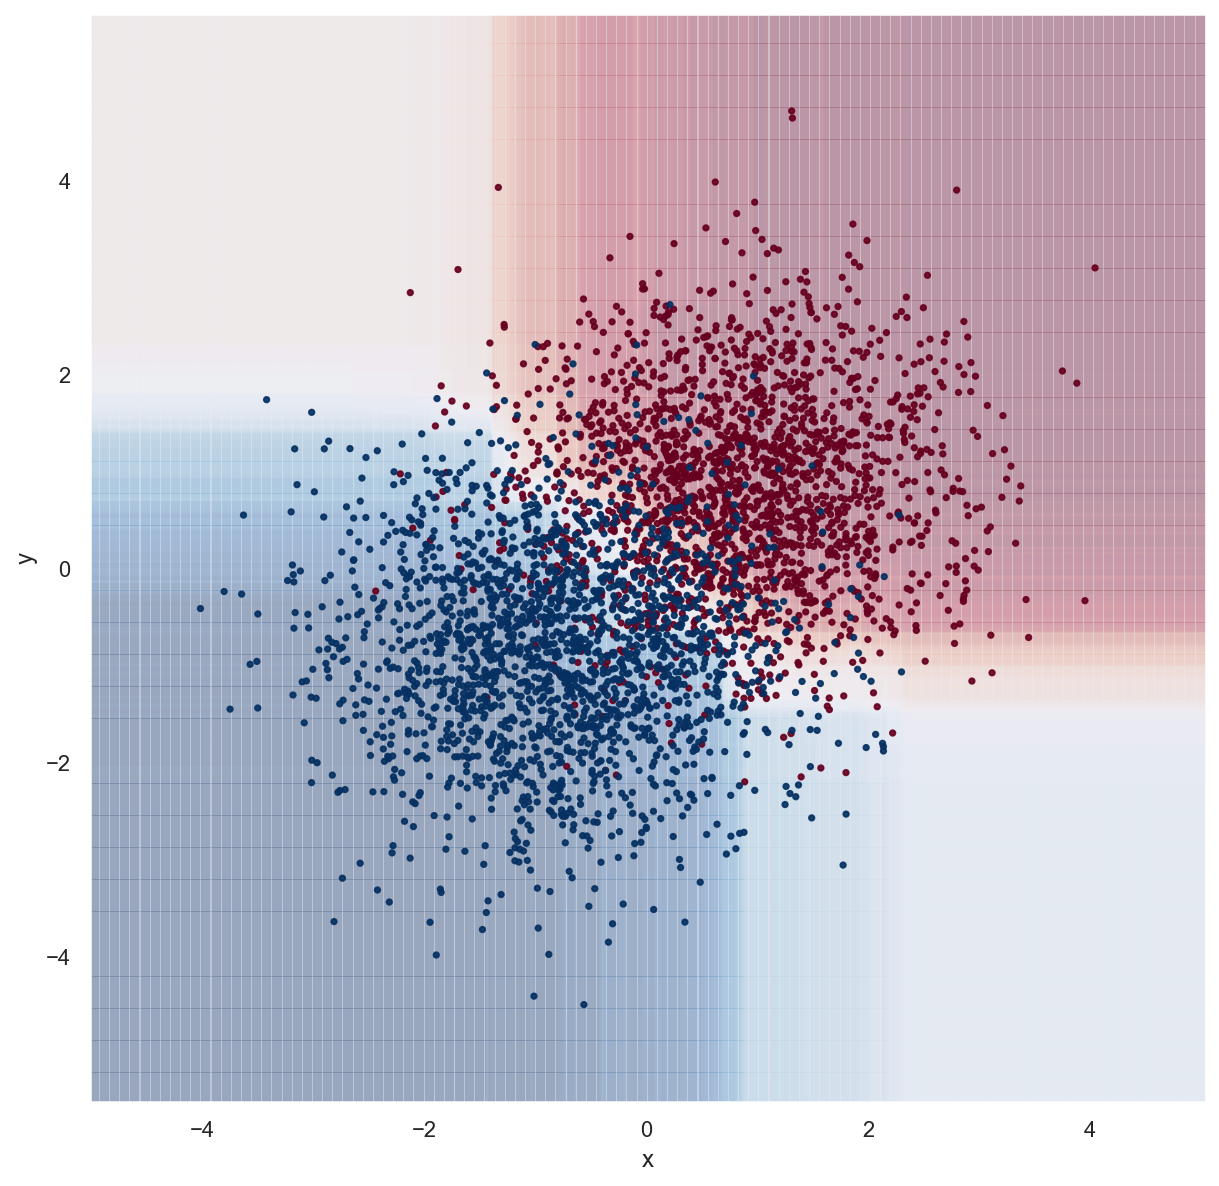

In [ ]:
clf = RandomForestClassifier(min_samples_split=100)
plot_predictions(x, y, clf, proba=True);

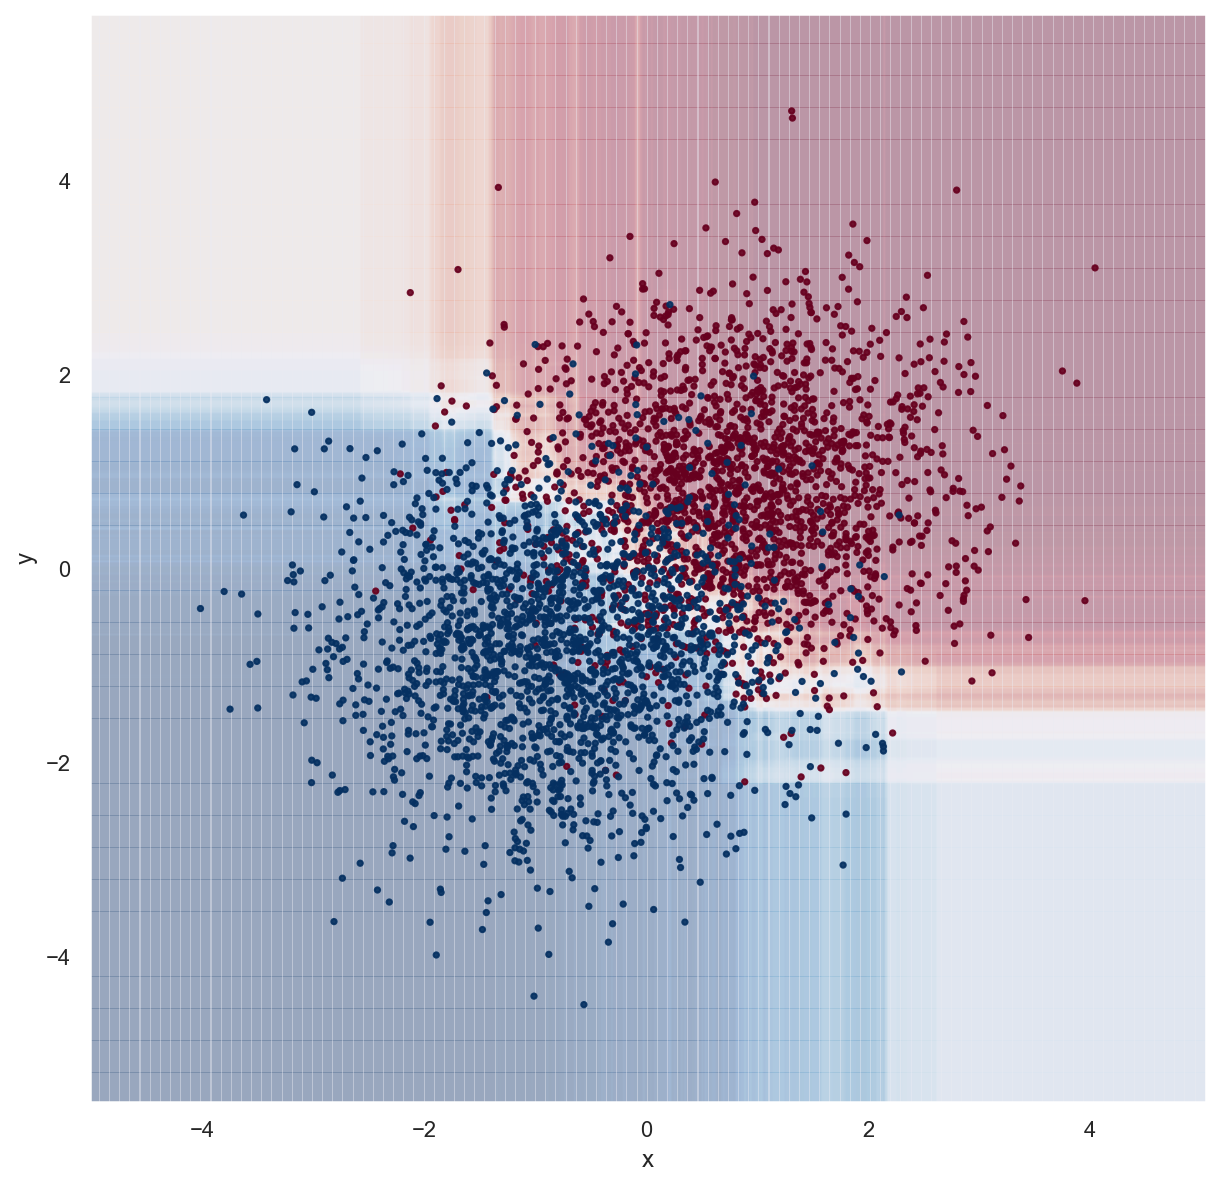

In [ ]:
clf = RandomForestClassifier(max_leaf_nodes=60)
plot_predictions(x, y, clf, proba=True);

После настройки архитектуры дерева следует повышать количество деревьев в ансамбле.  
Прирост качества после добавления каждого следующего дерева становится все меньше, поэтому следует добавлять деревья пока это разумно.

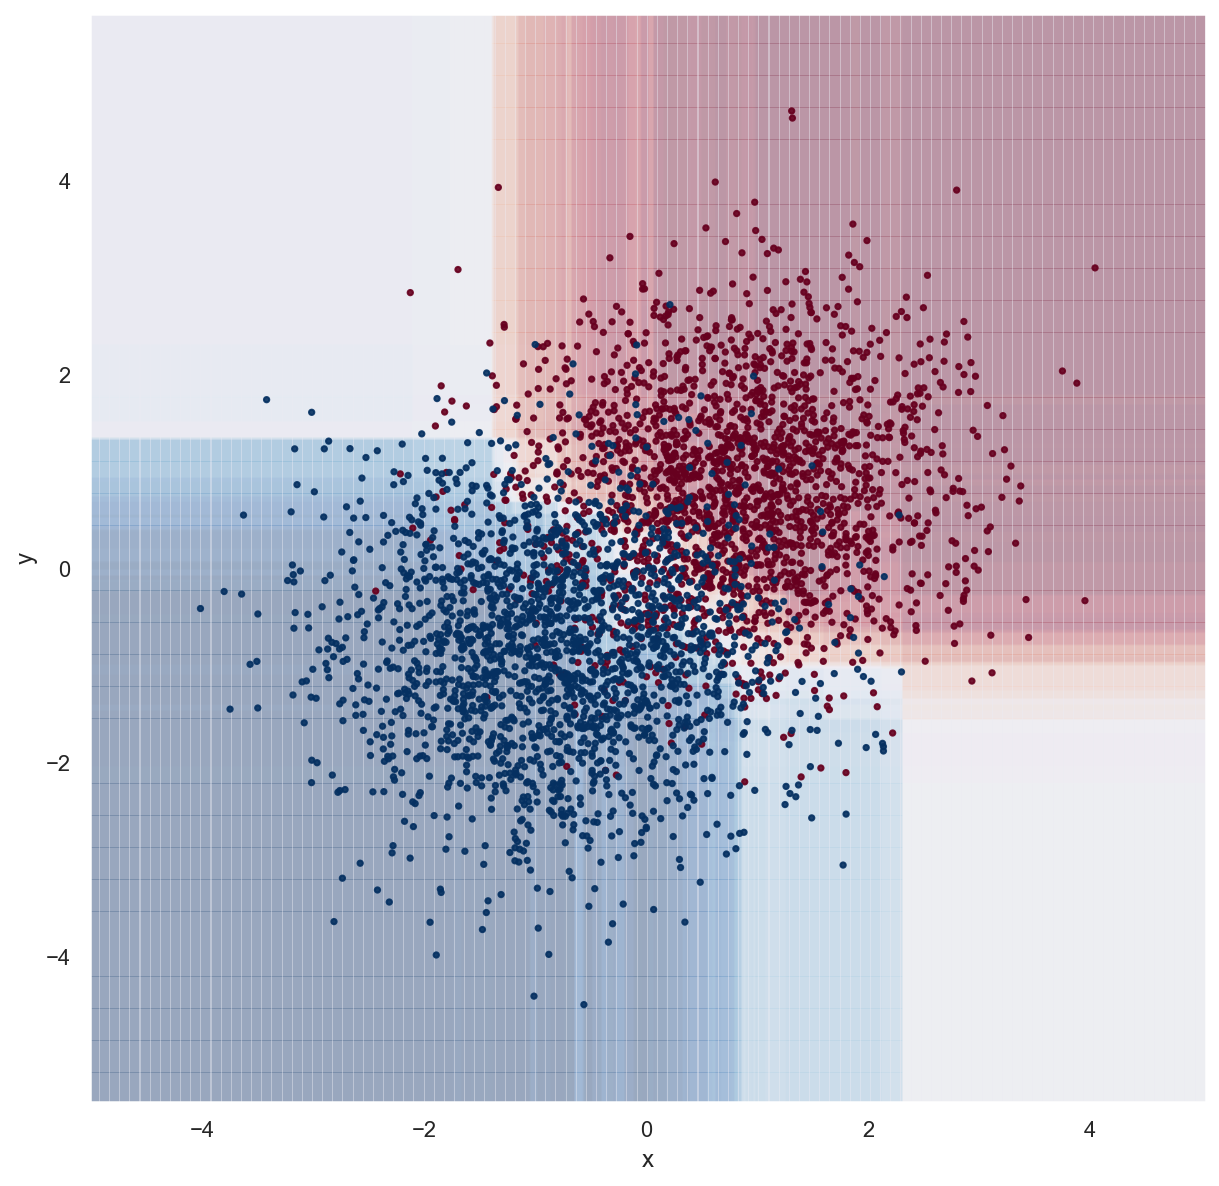

In [ ]:
clf = RandomForestClassifier(n_estimators=10, min_samples_leaf=25, n_jobs=-1)
plot_predictions(x, y, clf, proba=True);

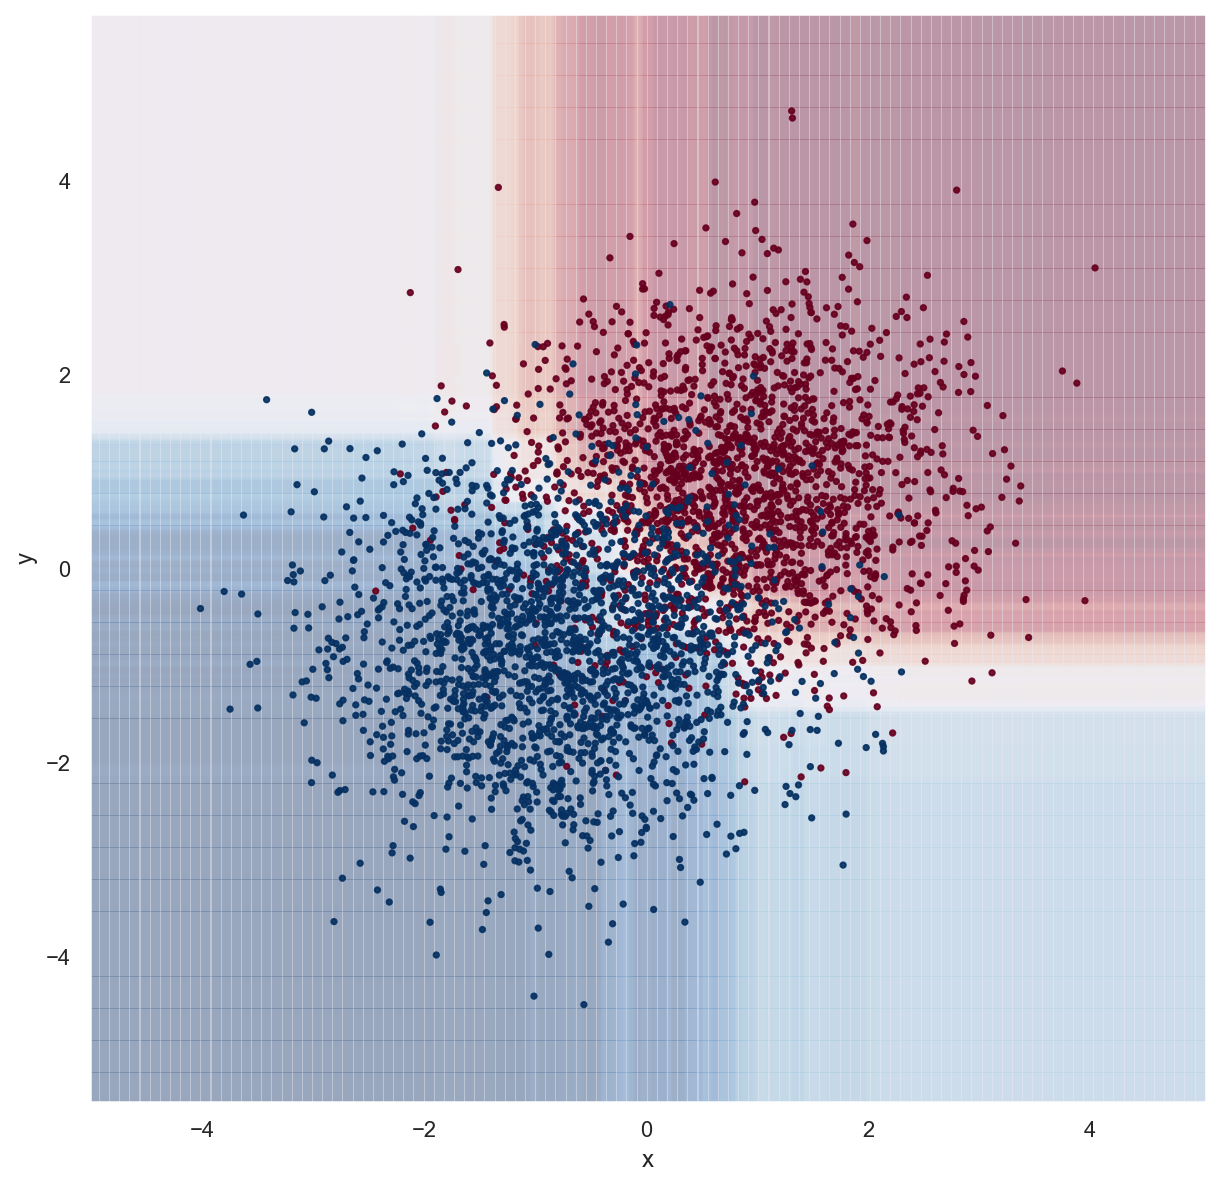

In [ ]:
clf = RandomForestClassifier(n_estimators=25, min_samples_leaf=25, n_jobs=-1)
plot_predictions(x, y, clf, proba=True);

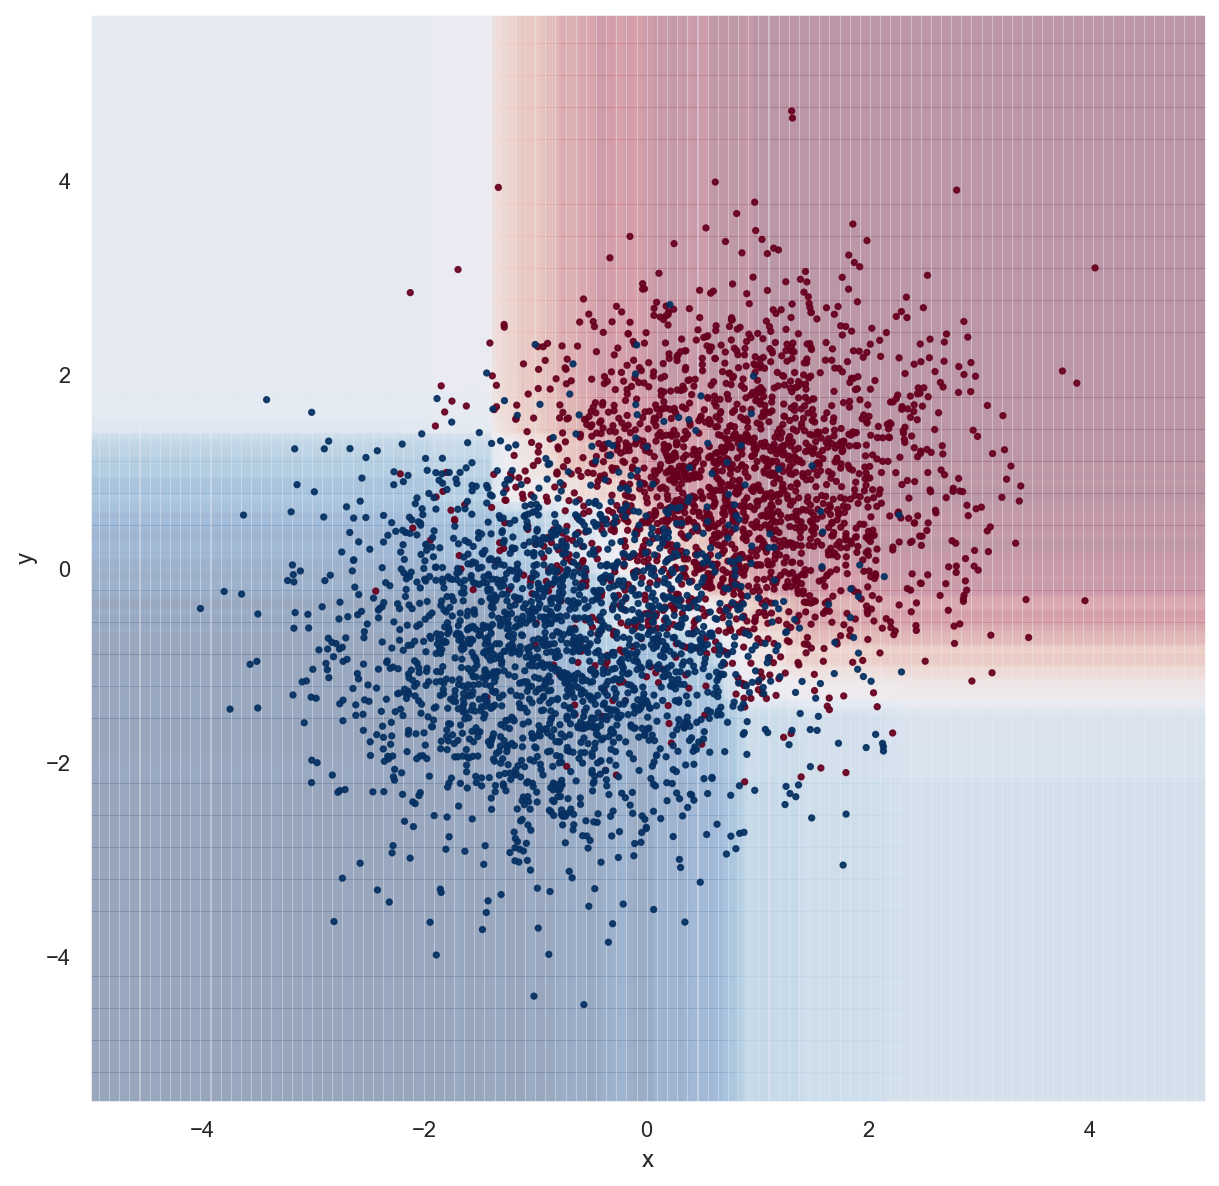

In [ ]:
clf = RandomForestClassifier(n_estimators=50, min_samples_leaf=25, n_jobs=-1)
plot_predictions(x, y, clf, proba=True);

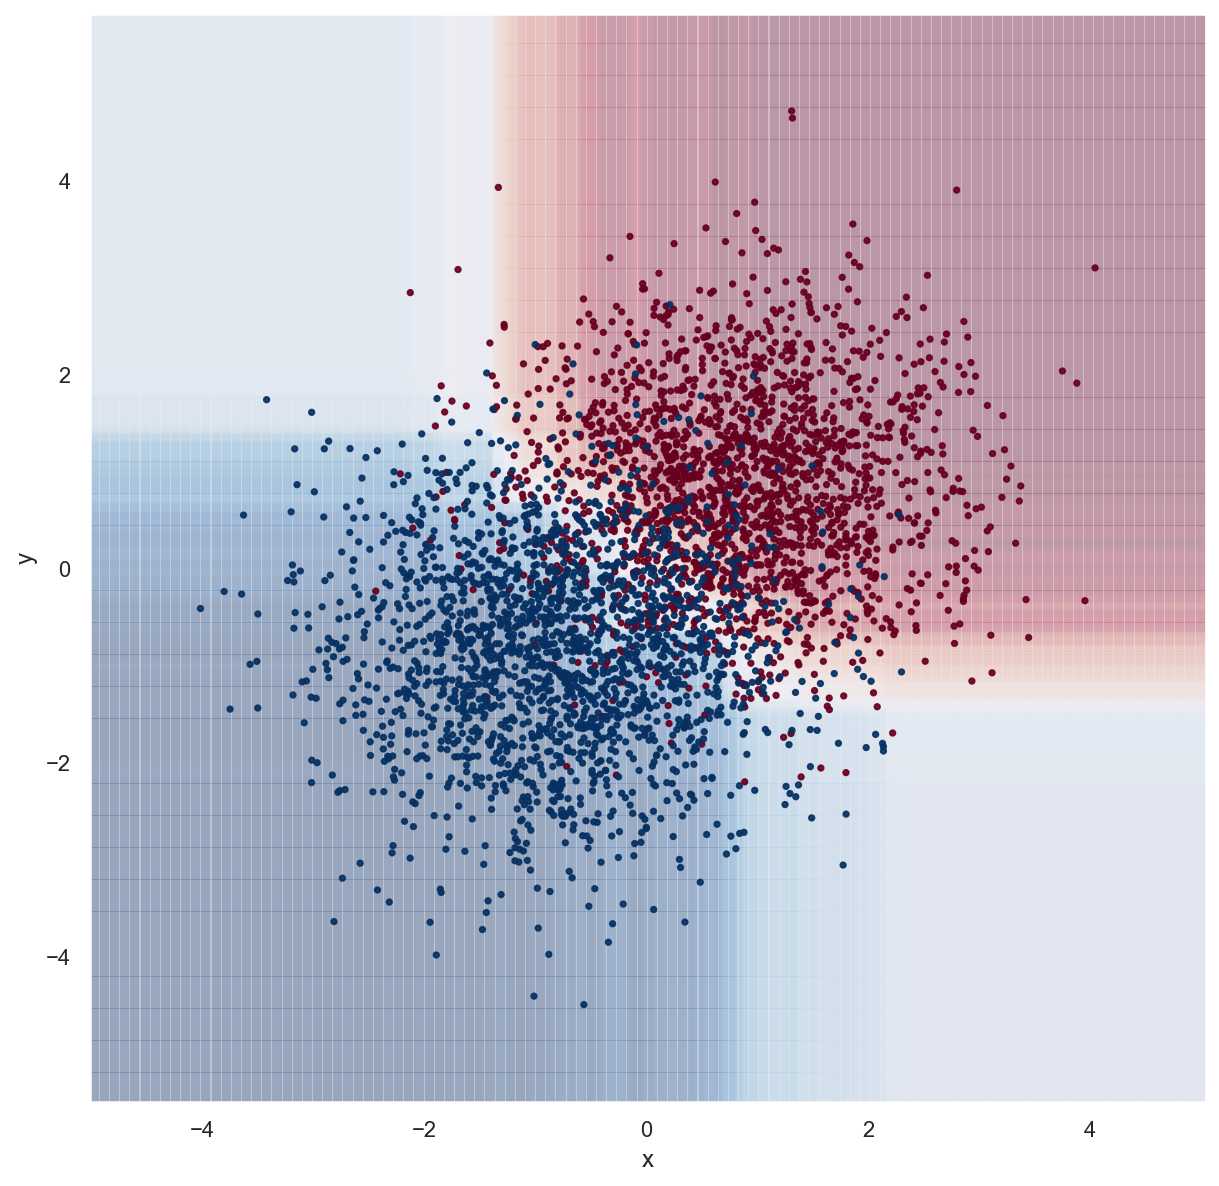

In [ ]:
clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=25, n_jobs=-1)
plot_predictions(x, y, clf, proba=True);

#### Важности признаков
Помимо оценки качества через Out-of-Bag Score случайный лес позволяет оценить "важность" каждого конкретного признака при построении ансамбля.

In [ ]:
df = pd.read_csv('data/HR.csv')
X = df.drop('left', axis='columns')
y = df.left

X.head(5)

last_evaluation  number_project  average_montly_hours  time_spend_company  \
0             0.53               2                   157                   3   
1             0.86               5                   262                   6   
2             0.88               7                   272                   4   
3             0.87               5                   223                   5   
4             0.52               2                   159                   3   

   Work_accident  promotion_last_5years  
0              0                      0  
1              0                      0  
2              0                      0  
3              0                      0  
4              0                      0

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=42)

In [ ]:
clf = RandomForestClassifier(n_estimators=200,
                             max_features=len(X.columns),
                             n_jobs=-1)
clf.fit(X_train, y_train);

In [ ]:
clf.feature_importances_

array([0.31259271, 0.15074485, 0.376748  , 0.12350735, 0.02826245,
       0.00814465])

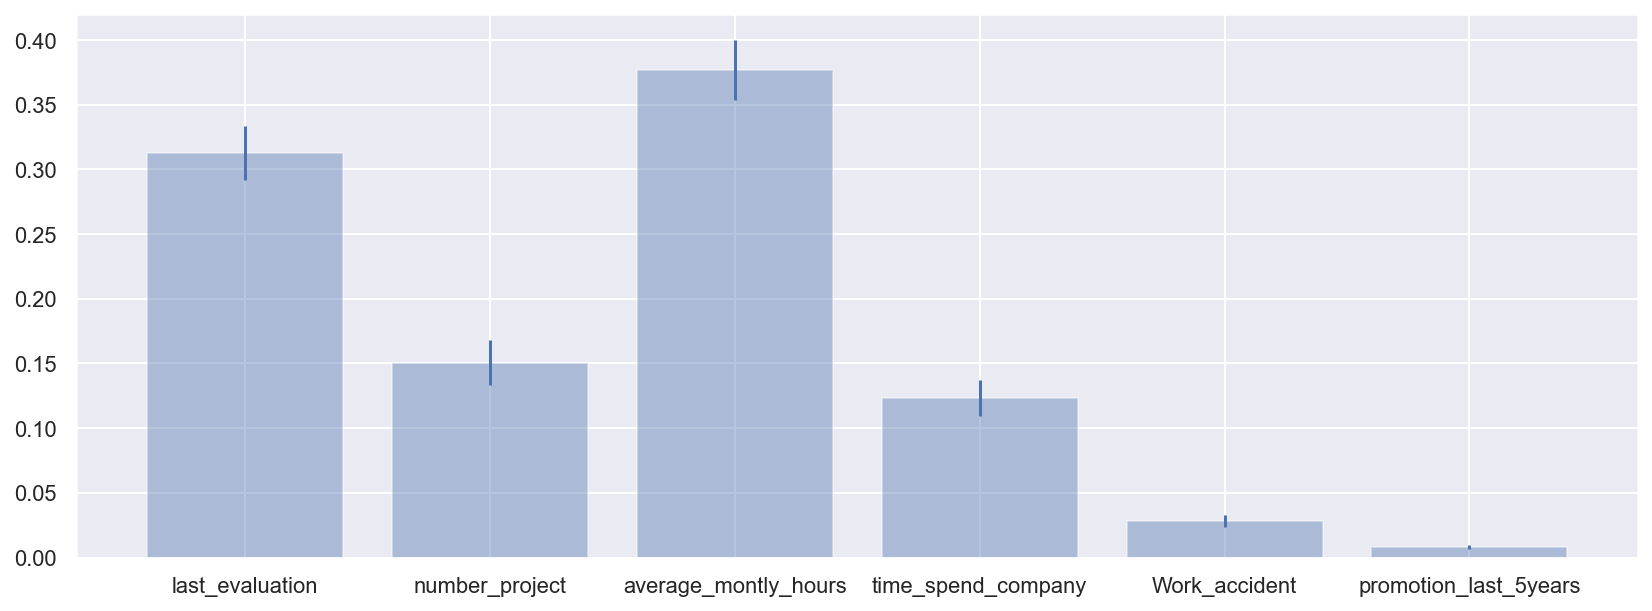

In [ ]:
importances_val = clf.feature_importances_
importances_std = np.std([tree.feature_importances_
                          for tree in clf.estimators_], axis=0)

plt.figure(figsize=(14, 5))
plt.bar(X.columns, clf.feature_importances_, yerr=importances_std, alpha=0.4, ecolor='C0');

Можем заметить что важности различаются в зависимости от допустимой свободы в структуре дерева: чем ее меньше, тем больше признаки друг на друга похожи, и тем больше разброс их важности.  

Так что же они обозначают? Автор деревьев в Scikit-Learn описывает [в ответе на Stack Overflow](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined/15821880#15821880) что происходит подсчет так называемых "gini importances". Происходит это так: каждый раз когда происходит разбиение по какому-то признаку во время построения дерева для него подсчитывается следующая характеристика:
$$ I = G_{parent} - G_{split\_left} - G_{split\_right},$$
где $G_{parent}, G_{split\_left}, G_{split\_right}$ $-$ значение критерия Джини для элементов в родительской вершине и в левом и правом потомке соответственно. Подсчет производится по out-of-bag объектам. Затем это значение усредняется по всем выполненным разбиениям.  
Критерий Джини подсчитывается следующим образом:
$$ G = \sum_{i=1}^{n\_classes} p_i (1 - p_i),$$
где $p_i - $ доля класса $i$ в разбиении.  

Такой механизм подсчета важностей не всегда надежен, есть его [критики](http://explained.ai/rf-importance/index.html).

Существуют другие механизмы подсчета важностей, например следующий: для каждой колонки подсчитать исходную точность алгоритма (accuracy или $R^2$ для классификации и регрессии соответственно) и точность после случайной перестановки значений в этой колонке. Точность полученная таким способом надежнее, но труднее в подсчете.  
Такой подсчет важностей реализован в библиотеке `rfpimp`.

In [ ]:
clf = rfpimp.RandomForestClassifier(n_estimators=30, max_depth=5, n_jobs=-1, oob_score=True)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=30, n_jobs=-1, oob_score=True)

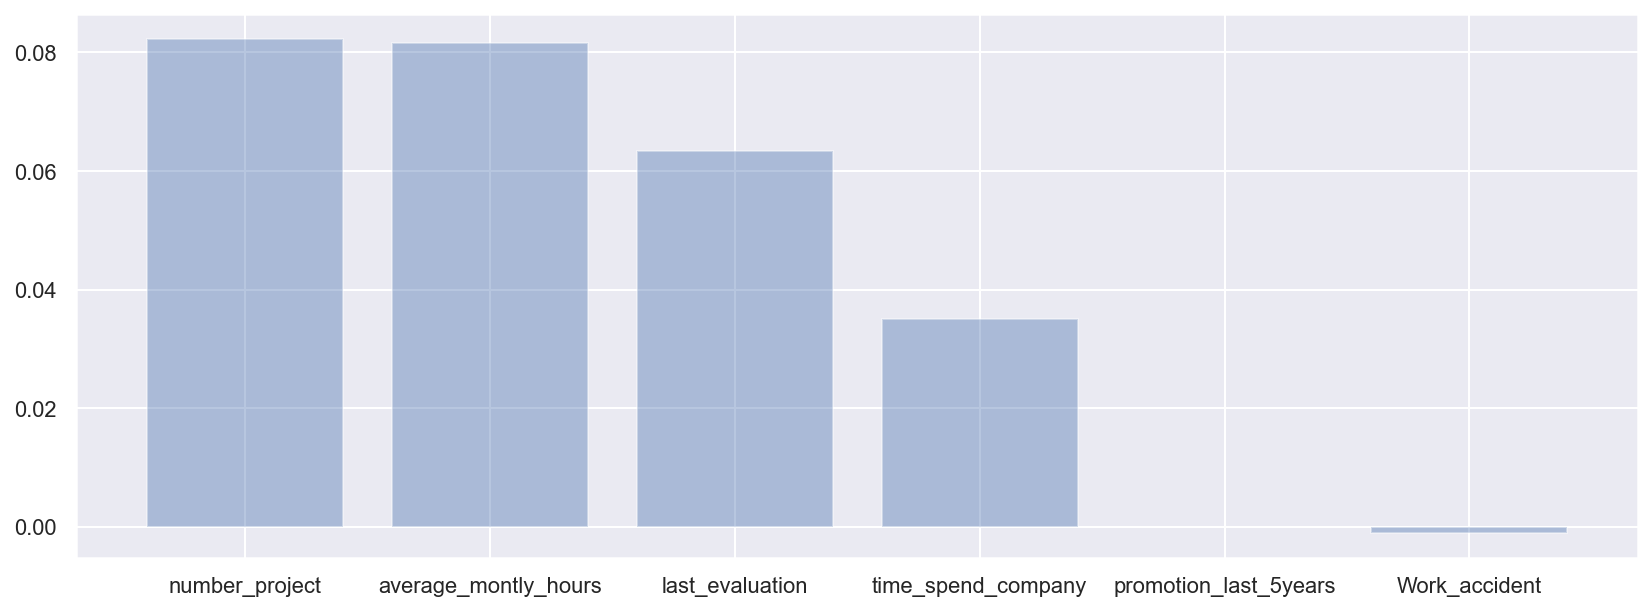

In [ ]:
importances = rfpimp.importances(clf, X_valid, y_valid, n_samples=len(X_valid))

plt.figure(figsize=(14, 5))
plt.bar(importances.index, importances.values.reshape(-1), alpha=0.4, ecolor='C0');

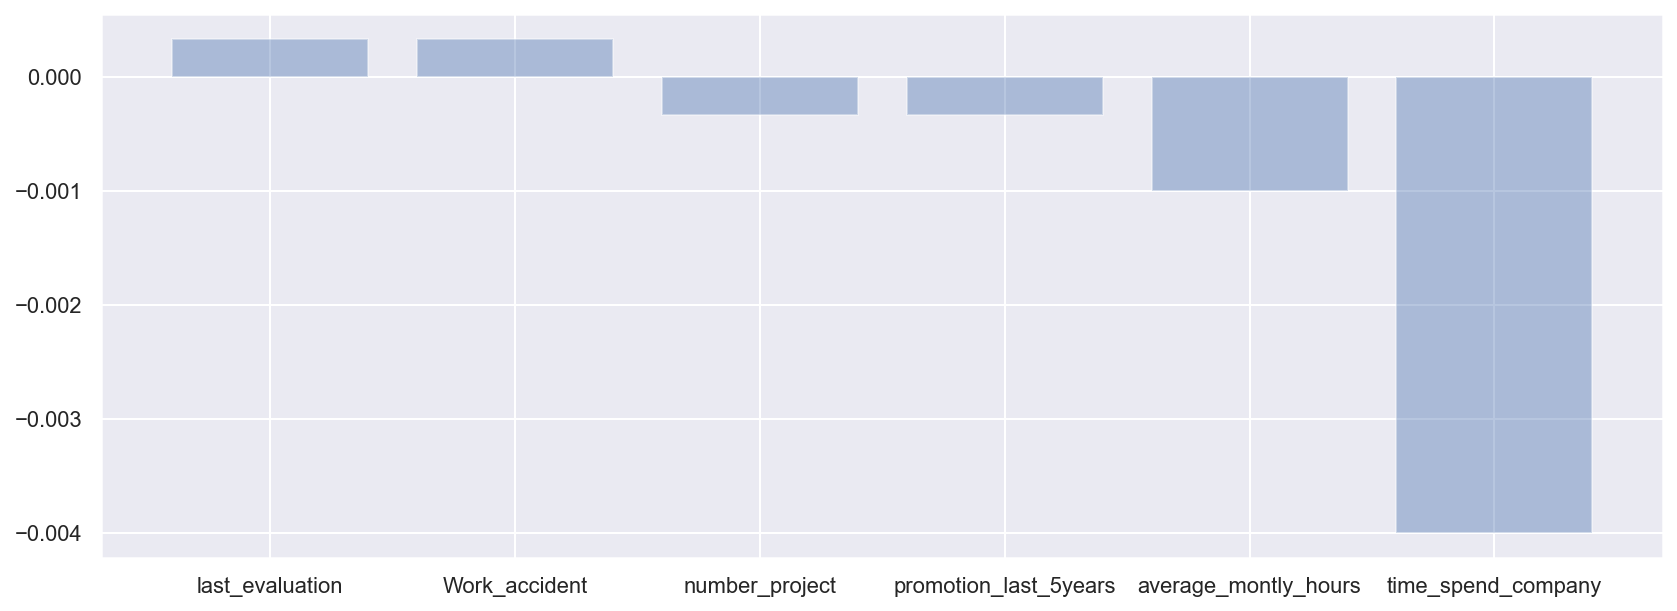

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X)
X_train_scaled, X_valid_scaled, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=42)

X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X.columns)
clf = LogisticRegression(C=1000000)
clf.fit(X_train_scaled, y_train)
importances = rfpimp.importances(clf,
                                 X_valid_scaled, y_valid,
                                 n_samples=len(X_valid))

plt.figure(figsize=(14, 5))
plt.bar(importances.index, importances.values.reshape(-1), alpha=0.4, ecolor='C0');

In [ ]:
np.corrcoef(y_valid, X_valid_scaled.Work_accident)

array([[ 1.        , -0.10186361],
       [-0.10186361,  1.        ]])

Что можно посмотреть:
* Туториал по важности признаков в случайном лесе: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
* Описание подсчета gini importances: https://stats.stackexchange.com/a/92843
* Репозиторий библиотеки rfpimp: https://github.com/parrt/random-forest-importances
* Критика gini importances: http://explained.ai/rf-importance/index.html

### 2.3. Бустинг 

* +: высокое качество модели.
* ~: умеренная склонность к переобучению, можно регулировать с помощью разных регуляризаций.
* -: сложность реализации. Но все написано за нас :)

## 3. Алгоритм градиентного бустинга

* На каждом шаге строится простая модель, например, дерево небольшой глубины.
* Целью обучения при построении очередного дерева уже является не исходная задача, а разность между исходной задачей и уже построенным ансамблем. Например, если мы решаем задачу регрессии, то мы из целевых меток вычитаем значения, предсказанные уже построенным лесом из n-1 дерева.
* Решать можно любую задачу, изменится только функция потерь. Для регрессии обычно используют MSE, для бинарной классификации бинарную кросс-энтропию, и т. п.
* Для построения очередного дерева нужно решить следующие подзадачи:
  * Найти оптимальные разбиения пространства факторов либо выбрать набор факторов для каждого из узлов дерева, если факторы уже бинаризованы. Эта задача обычно решается с помощью оценки количества информации для каждого из разбиений, например, с помощью индекса Джинни.
  * Найти оптимальные значения в листьях деревьев. Здесь работает градиентный спуск либо метод Ньютона.
  * В процессе могут применяться различные регуляризации: ограничение весов в листьях, шаги на learning_rate, а не в оптимальную точку, случайный выбор фичей/примеров.


In [ ]:
from sklearn.datasets import load_boston

In [ ]:
def compute_loss(y, y_hat): 
    return ((y - y_hat) ** 2) / 2

In [ ]:
def loss_gradient(y, y_hat): 
    return -(y - y_hat)

In [ ]:
boston = load_boston() 
X = boston.data 
y = boston.target 
y_hat = np.array([y_train.mean()] * len(y))
compute_loss(y, y_hat).mean()

42.24156892266521

In [ ]:
def gradient_boost_mse(X, y, n_estimators, learning_rate, max_depth=1, verbose=False): 
    regressors = [] 
    y_hat = np.array([y.mean()] * len(y)) 
    f0 = y_hat 
    if verbose:
        print('Starting loss:', compute_loss(y, y_hat).mean())
        
    for i in range(n_estimators): 
        residuals = -loss_gradient(y, y_hat) 
        regressor = DecisionTreeRegressor(max_depth=max_depth) 
        regressor.fit(X, residuals) 
        regressors.append(regressor) 
        predictions = regressor.predict(X) 
        y_hat = y_hat + learning_rate * predictions
        
        if verbose:
            print(compute_loss(y, y_hat).mean()) 
        
        if i == n_estimators - 1:
            print('MSE on train', compute_loss(y, y_hat).mean())
    return regressors, f0

In [ ]:
def gradient_boost_mse_predict(regressors, f0, X, learning_rate):
    y_hat = np.array([f0[0]] * len(X)) 
    for regressor in regressors: 
        y_hat = y_hat + learning_rate * regressor.predict(X) 
    return y_hat

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [ ]:
regressors, f0 = gradient_boost_mse(X_train, y_train, 50, 0.05, max_depth=3) 

MSE on train 2.9056473541868244


In [ ]:
mse_test = compute_loss(y_test, gradient_boost_mse_predict(regressors, f0, X_test, 0.05)).mean() 
print('MSE on test', mse_test)

MSE on test 6.576524392867772


Теперь посмотрим на стандартную реализацию из sklearn

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor(n_estimators=25, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
compute_loss(y_test, y_pred).mean()

6.494408400364777

## 4. Стекинг

* Применяется для борьбы с переобучением и для большей обобщающей способности.
* Идея заключается в том, чтобы обучить несколько моделей, а потом скомбинировать ответ из них с помощью другой модели (это может быть как простое голосование в случае классификации, так и регрессия, и любая другая модель). Эта модель уже будет иметь небольшое количество признаков, равное количеству базовых моделей.
* Важно избегать data leakage - тренировать базовые модели и модель верхнего уровня надо на непересекающихся и на независимых множествах примеров. Часто для этих целей используют аналог кросс-валидации, бутстрэппинг или разбиение по времени.
* Под аналогом кросс-валидации мы понимаем следующий подход. Берём часть данных и откладываем их для обучения модели верхнего уровня. Оставшиеся данные разбиваем на m частей, убираем каждую из m частей, тренируем на оставшихся одну из базовых моделей. Затем тренируем модель верхнего уровня на заранее отложенных данных.
* Бутстрэппинг работает так. Для генерации очередного датасета для базовой модели мы случайным образом выбираем n примеров с повторением (т. е., каждый из примеров может встречаться в новом датасете несколько раз). Мы можем повторить этот процесс столько раз сколько моделей нам нужно получить.
* Разбиение по времени обычно применяется для выделения данных для обучения модели верхнего уровня. При таком подходе модель верхнего уровня всегда тренируется на более свежих примерах, чем базовые модели. Это позволяет избежать зависимостей/переобучения (более точно - data/feature leakage), в таком случае мы гарантируем, что модель верхнего уровня не усилит случайные предположения, образовавшиеся при обучении базовых моделей.


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from vecstack import stacking

In [ ]:
df = pd.read_csv('data/HR.csv')
X = df.drop('left', axis='columns')
y = df.left
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=42)

In [ ]:
models = [
    KNeighborsClassifier(n_neighbors=5,
                        n_jobs=-1),
        
    RandomForestClassifier(random_state=0, n_jobs=-1, 
                           n_estimators=100, max_depth=3),
        
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=100, max_depth=3, use_label_encoder=False, eval_metric='logloss')
]

In [ ]:
S_train, S_test = stacking(models,                   
                           X_train, y_train, X_valid,   
                           regression=False, 
                           mode='oof_pred_bag', 
                           needs_proba=False,
                           save_dir=None, 
                           metric=accuracy_score, 
                           n_folds=4, 
                           stratified=True,
                           shuffle=True,  
                           random_state=0,    
                           verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsClassifier]
    fold  0:  [0.73533333]
    fold  1:  [0.75166667]
    fold  2:  [0.73333333]
    fold  3:  [0.73924642]
    ----
    MEAN:     [0.73989494] + [0.00712140]
    FULL:     [0.73989499]

model  1:     [RandomForestClassifier]
    fold  0:  [0.74666667]
    fold  1:  [0.73133333]
    fold  2:  [0.73900000]
    fold  3:  [0.73224408]
    ----
    MEAN:     [0.73731102] + [0.00616010]
    FULL:     [0.73731144]

model  2:     [XGBClassifier]
    fold  0:  [0.78633333]
    fold  1:  [0.78233333]
    fold  2:  [0.77500000]
    fold  3:  [0.78692898]
    ----
    MEAN:     [0.78264891] + [0.00475656]
    FULL:     [0.78264855]



In [ ]:
model_meta = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                      n_estimators=100, max_depth=3, use_label_encoder=False, eval_metric='logloss')
    
model_meta = model_meta.fit(S_train, y_train)
y_pred_meta = model_meta.predict(S_test)
print('Final prediction score for meta model: %.8f' % accuracy_score(y_valid, y_pred_meta))

Final prediction score for meta model: 0.77966667


In [ ]:
model = RandomForestClassifier(random_state=0, n_estimators=100, max_depth=3)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
print('Final prediction score for simple model: %.8f' % accuracy_score(y_valid, y_pred))

Final prediction score for simple model: 0.73266667


## Ссылки про поиск аномалий

* Обзоры методов: [1](https://towardsdatascience.com/how-to-use-machine-learning-for-anomaly-detection-and-condition-monitoring-6742f82900d7), [2](https://www.kdnuggets.com/2019/10/anomaly-detection-explained.html)
* Туториалы: [1](https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623), [2](https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1)
* Статьи и код: [очень много всего](https://github.com/yzhao062/anomaly-detection-resources#31-multivariate-data)
* Поиск аномалий в реальном времени: [туториал 1](https://towardsdatascience.com/real-time-time-series-anomaly-detection-981cf1e1ca13), [туториал 2](https://towardsdatascience.com/detecting-real-time-and-unsupervised-anomalies-in-streaming-data-a-starting-point-760a4bacbdf8), [статья](https://www.sciencedirect.com/science/article/pii/S0925231217309864)